# LeNet-5 手写数字识别 (PyTorch + TensorBoardX)

此笔记展示使用经典 LeNet-5 结构在 MNIST 数据集上的训练示例。使用 `tensorboardX` 记录训练指标并演示如何可视化。仅使用 PyTorch、torchvision、numpy 与 matplotlib。

In [ ]:
# Imports
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter


In [3]:
# 定义 LeNet-5（基于经典结构的 PyTorch 实现）
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        # 输入: 1 x 32 x 32 (原始 LeNet 使用 32x32 输入)，MNIST 为 28x28，我们将 pad 到 32x32
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),  # -> 6 x 28 x 28 if input 28 -> we'll pad earlier
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),       # -> 6 x 14 x 14
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),       # -> 16 x 5 x 5 (if padded to 32)
            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 测试模型构建
model = LeNet5()
print(model)

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [4]:
# 数据准备：MNIST (训练/测试)，使用现有的 ./MNIST 数据并禁用下载；将 28x28 pad 到 32x32 以匹配 LeNet 原始设置
batch_size = 64
transform = transforms.Compose([
    transforms.Pad(2),               # 28 -> 32
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# root 指向当前目录 '.'，torchvision 会在 './MNIST' 下查找 raw/processed
train_dataset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print('Train samples:', len(train_dataset), 'Test samples:', len(test_dataset))

Train samples: 60000 Test samples: 10000


In [ ]:
# 训练与验证函数（增强 TensorBoard 可视化）
import itertools

def log_sample_images(writer, images, global_step, tag_prefix="train"):
    # 仅取前 8 张
    grid = make_grid(images[:8], nrow=4, normalize=True, scale_each=True)
    writer.add_image(f"{tag_prefix}/samples", grid, global_step)


def train(model, device, train_loader, optimizer, criterion, epoch, writer, log_interval=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        global_step = epoch * len(train_loader) + batch_idx
        # 记录学习率与 batch loss（更细粒度）
        writer.add_scalar('metrics/train/batch_loss', loss.item(), global_step)
        writer.add_scalar('metrics/train/lr', optimizer.param_groups[0]['lr'], global_step)

        # 间隔记录样本图像与卷积核权重直方图
        if batch_idx == 0:
            log_sample_images(writer, data, global_step, tag_prefix="images/train")
        if (batch_idx + 1) % (log_interval * 2) == 0:
            writer.add_histogram('weights/conv1', model.features[0].weight.detach().cpu(), global_step)

        if (batch_idx + 1) % log_interval == 0:
            avg_loss = running_loss / log_interval
            acc = 100. * correct / total
            writer.add_scalar('metrics/train/avg_loss', avg_loss, global_step)
            writer.add_scalar('metrics/train/avg_accuracy', acc, global_step)
            print(f'Epoch: {epoch} [{batch_idx+1}/{len(train_loader)}]  Loss: {avg_loss:.4f}  Acc: {acc:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0


def _confusion_matrix(num_classes, preds, targets):
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for p, t in zip(preds, targets):
        cm[t, p] += 1
    return cm


def _plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = cm[i, j].item()
        if val > 0:
            ax.text(j, i, val, ha='center', va='center', color='black', fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def test(model, device, test_loader, criterion, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    mis_images = []
    mis_pairs = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss_batch = criterion(output, target).item()
            test_loss += loss_batch * data.size(0)
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            all_preds.append(predicted.cpu())
            all_targets.append(target.cpu())
            # 收集前若干误分类样本
            mismask = predicted.ne(target)
            if mismask.any() and len(mis_images) < 16:
                idxs = torch.where(mismask)[0]
                for idx in idxs:
                    if len(mis_images) >= 16:
                        break
                    mis_images.append(data[idx].cpu())
                    mis_pairs.append((int(target[idx].item()), int(predicted[idx].item())))
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')
    writer.add_scalar('metrics/test/loss', test_loss, epoch)
    writer.add_scalar('metrics/test/accuracy', acc, epoch)

    # 记录误分类样本图像
    if mis_images:
        mis_stack = torch.stack(mis_images)
        grid = make_grid(mis_stack, nrow=4, normalize=True, scale_each=True)
        writer.add_image('images/test/misclassified', grid, epoch)

    # 混淆矩阵
    preds_cat = torch.cat(all_preds)
    targets_cat = torch.cat(all_targets)
    cm = _confusion_matrix(10, preds_cat, targets_cat)
    fig_cm = _plot_confusion_matrix(cm, [str(i) for i in range(10)])
    writer.add_figure('metrics/test/confusion_matrix', fig_cm, epoch)
    plt.close(fig_cm)

    return test_loss, acc


In [6]:
# 自动启动 TensorBoard 并打开浏览器（在训练前执行）
import os, time, sys, subprocess, webbrowser

# 与训练日志目录保持一致
tb_logdir = './runs/lenet_mnist'
os.makedirs(tb_logdir, exist_ok=True)


def _start_tensorboard(logdir: str, preferred_port: int = 6006) -> str:
    """优先通过 TensorBoard API 启动；失败则尝试子进程启动。返回访问 URL。"""
    try:
        from tensorboard import program  # 需要安装 `tensorboard`
        tb = program.TensorBoard()
        tb.configure(argv=[None, '--logdir', logdir, '--port', str(preferred_port), '--host', '127.0.0.1'])
        url = tb.launch()
        return url
    except Exception:
        # 退回到子进程方式：python -m tensorboard ...
        try:
            subprocess.Popen(
                [sys.executable, '-m', 'tensorboard', f'--logdir={logdir}', f'--port={preferred_port}', '--host=127.0.0.1'],
                stdout=subprocess.DEVNULL,
                stderr=subprocess.STDOUT,
            )
            return f'http://127.0.0.1:{preferred_port}'
        except Exception as e2:
            print('无法启动 TensorBoard，请先安装: pip install tensorboard')
            raise e2


def start_tensorboard_with_fallbacks(logdir: str, base_port: int = 6006, tries: int = 3) -> str:
    for k in range(tries):
        port = base_port + k
        try:
            url = _start_tensorboard(logdir, preferred_port=port)
            return url
        except Exception:
            continue
    # 最后返回默认 URL（不保证可用，仅用于提示）
    return f'http://127.0.0.1:{base_port}'


# 启动并打开浏览器
_tb_url = start_tensorboard_with_fallbacks(tb_logdir, base_port=6006, tries=3)
print('TensorBoard URL:', _tb_url)
# 稍等片刻，确保服务已就绪
time.sleep(2)
try:
    webbrowser.open(_tb_url)
except Exception:
    print('请在浏览器中手动打开:', _tb_url)

TensorBoard URL: http://127.0.0.1:6006/


In [7]:
# 主运行：设置设备、模型、优化器和训练循环
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# TensorBoardX writer（写入 runs/lenet_mnist）
logdir = './runs/lenet_mnist'
os.makedirs(logdir, exist_ok=True)
writer = SummaryWriter(logdir)

start_epoch = 1
epochs = 5  # 可以根据需要调整
for epoch in range(start_epoch, start_epoch + epochs):
    t0 = time.time()
    train(model, device, train_loader, optimizer, criterion, epoch, writer)
    test(model, device, test_loader, criterion, epoch, writer)
    print(f'Epoch {epoch} finished in {time.time() - t0:.1f}s')

# 保存模型
model_path = './lenet_mnist.pth'
torch.save(model.state_dict(), model_path)
print('Model saved to', model_path)
writer.close()

Epoch: 1 [100/938]  Loss: 1.5120  Acc: 54.59%
Epoch: 1 [200/938]  Loss: 0.5016  Acc: 86.27%
Epoch: 1 [200/938]  Loss: 0.5016  Acc: 86.27%
Epoch: 1 [300/938]  Loss: 0.3489  Acc: 89.64%
Epoch: 1 [300/938]  Loss: 0.3489  Acc: 89.64%
Epoch: 1 [400/938]  Loss: 0.2964  Acc: 91.67%
Epoch: 1 [400/938]  Loss: 0.2964  Acc: 91.67%
Epoch: 1 [500/938]  Loss: 0.2333  Acc: 93.08%
Epoch: 1 [500/938]  Loss: 0.2333  Acc: 93.08%
Epoch: 1 [600/938]  Loss: 0.2147  Acc: 93.78%
Epoch: 1 [600/938]  Loss: 0.2147  Acc: 93.78%
Epoch: 1 [700/938]  Loss: 0.1707  Acc: 95.22%
Epoch: 1 [700/938]  Loss: 0.1707  Acc: 95.22%
Epoch: 1 [800/938]  Loss: 0.1581  Acc: 95.41%
Epoch: 1 [800/938]  Loss: 0.1581  Acc: 95.41%
Epoch: 1 [900/938]  Loss: 0.1498  Acc: 95.67%
Epoch: 1 [900/938]  Loss: 0.1498  Acc: 95.67%

Test set: Average loss: 0.1150, Accuracy: 9668/10000 (96.68%)

Epoch 1 finished in 17.0s

Test set: Average loss: 0.1150, Accuracy: 9668/10000 (96.68%)

Epoch 1 finished in 17.0s
Epoch: 2 [100/938]  Loss: 0.1161  Acc:

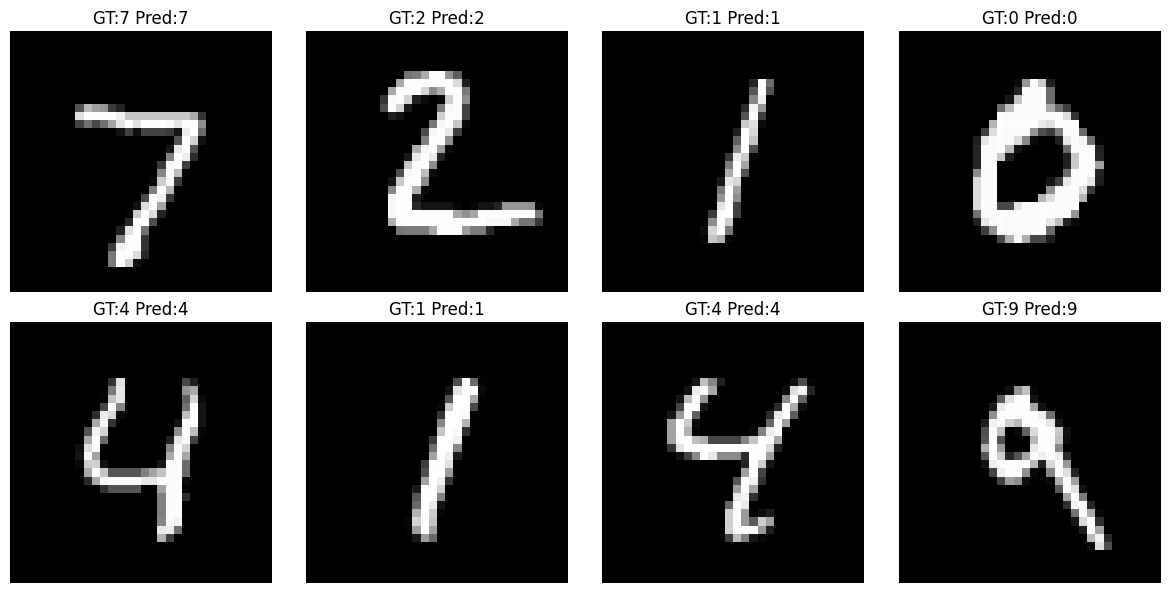

In [8]:
# 示例：加载保存的模型并可视化若干预测结果
# 加载模型
model = LeNet5()
model.load_state_dict(torch.load('./lenet_mnist.pth', map_location='cpu'))
model.eval()

# 取几张测试图像并预测
examples = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if i >= 1:
            break
        outputs = model(data)
        preds = outputs.argmax(dim=1).numpy()
        for j in range(min(8, data.size(0))):
            img = data[j].squeeze().numpy()
            examples.append(img)
            labels.append((int(target[j].item()), int(preds[j].item())))

# 绘制
plt.figure(figsize=(12, 6))
for idx, img in enumerate(examples):
    plt.subplot(2, 4, idx+1)
    plt.imshow(img, cmap='gray')
    gt, pr = labels[idx]
    plt.title(f'GT:{gt} Pred:{pr}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 本地手写窗口（Tkinter）

- 运行下一个单元将打开一个本地窗口。
- 操作：按住左键在白板上书写；点击“识别”进行推断；“清空”重置画布；“退出”关闭窗口。
- 说明：此窗口使用 Tkinter（Windows 通常自带）。若环境未安装 Tk 支持，可能无法启动。

In [9]:
# 本地手写窗口：Tkinter 画布 + LeNet-5 推理
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.nn.functional as F

# Tkinter 可能在某些环境不可用
try:
    import tkinter as tk
except Exception as e:
    print("未能导入 Tkinter：", e)
    raise

# 复用已定义的 LeNet5，如果此单元单独运行则做一次定义
try:
    LeNet5
except NameError:
    class LeNet5(nn.Module):
        def __init__(self, num_classes=10):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, stride=1),
                nn.Tanh(),
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.Conv2d(6, 16, kernel_size=5, stride=1),
                nn.Tanh(),
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 120, kernel_size=5, stride=1),
                nn.Tanh()
            )
            self.classifier = nn.Sequential(
                nn.Linear(120, 84),
                nn.Tanh(),
                nn.Linear(84, num_classes)
            )
        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x

# 加载模型（CPU 推理）
_device = torch.device('cpu')
_model = LeNet5().to(_device)
weights_path = './lenet_mnist.pth'
if os.path.exists(weights_path):
    _model.load_state_dict(torch.load(weights_path, map_location=_device))
    _model.eval()
else:
    print('警告：未找到模型权重 ./lenet_mnist.pth，请先运行训练单元保存模型。')

_MEAN, _STD = 0.1307, 0.3081


def _preprocess_pil(pil_img: Image.Image) -> torch.Tensor:
    """将 PIL 图像转换为 1×1×32×32 标准化张量（与训练一致）。"""
    if pil_img.mode != 'L':
        pil_img = pil_img.convert('L')
    pil_img = pil_img.resize((28, 28), Image.NEAREST)
    arr = np.array(pil_img).astype(np.float32) / 255.0
    arr = 1.0 - arr  # 画布白底黑字 -> MNIST 黑底白字
    arr = (arr - _MEAN) / _STD
    arr = np.pad(arr, pad_width=((2, 2), (2, 2)), mode='constant', constant_values=0.0)
    ten = torch.from_numpy(arr)[None, None, :, :].to(_device)
    return ten


def _predict_from_pil(pil_img: Image.Image):
    if _model is None:
        return {str(i): 0.0 for i in range(10)}
    x = _preprocess_pil(pil_img)
    with torch.no_grad():
        logits = _model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    return {str(i): float(probs[i]) for i in range(10)}


# === Tkinter 手写窗口 ===
CANVAS_SIZE = 280            # 画布像素大小（放大版）
BRUSH_WIDTH = 12             # 笔刷粗细

root = tk.Tk()
root.title('MNIST 手写数字识别 (LeNet-5) - 本地窗口')

canvas = tk.Canvas(root, width=CANVAS_SIZE, height=CANVAS_SIZE, bg='white')
canvas.pack(padx=8, pady=8)

# 用于推理的灰度图缓存（白底）
buffer_img = Image.new('L', (CANVAS_SIZE, CANVAS_SIZE), color=255)
buffer_draw = ImageDraw.Draw(buffer_img)

last_pos = {'x': None, 'y': None}


def on_button_press(event):
    last_pos['x'], last_pos['y'] = event.x, event.y


def on_move(event):
    lx, ly = last_pos['x'], last_pos['y']
    if lx is None or ly is None:
        last_pos['x'], last_pos['y'] = event.x, event.y
        return
    x, y = event.x, event.y
    canvas.create_line(lx, ly, x, y, width=BRUSH_WIDTH, fill='black', capstyle=tk.ROUND, smooth=True)
    buffer_draw.line([lx, ly, x, y], fill=0, width=BRUSH_WIDTH)
    last_pos['x'], last_pos['y'] = x, y


def on_button_release(event):
    last_pos['x'], last_pos['y'] = None, None


def clear_canvas():
    canvas.delete('all')
    buffer_draw.rectangle([(0, 0), (CANVAS_SIZE, CANVAS_SIZE)], fill=255)
    result_var.set('结果：')


def predict_canvas():
    probs = _predict_from_pil(buffer_img)
    # 取 Top-3 显示
    items = sorted([(int(k), v) for k, v in probs.items()], key=lambda kv: kv[1], reverse=True)[:3]
    text = '结果：' + '  '.join([f'{k}: {v*100:.2f}%' for k, v in items])
    result_var.set(text)


btn_frame = tk.Frame(root)
btn_frame.pack(fill='x', padx=8, pady=4)

tk.Button(btn_frame, text='识别', command=predict_canvas).pack(side='left', padx=4)
tk.Button(btn_frame, text='清空', command=clear_canvas).pack(side='left', padx=4)
tk.Button(btn_frame, text='退出', command=root.destroy).pack(side='right', padx=4)

result_var = tk.StringVar(value='结果：')
result_label = tk.Label(root, textvariable=result_var, anchor='w')
result_label.pack(fill='x', padx=8, pady=4)

canvas.bind('<ButtonPress-1>', on_button_press)
canvas.bind('<B1-Motion>', on_move)
canvas.bind('<ButtonRelease-1>', on_button_release)

# 启动窗口（注意：在某些 Jupyter 环境中主线程阻塞是预期行为）
try:
    root.mainloop()
except Exception as e:
    print('Tkinter 主循环启动失败：', e)
